# Week 5 - Sampling & Reliability

Up until this week, we have assumed that the corpus you have used for analysis assignments represented a *meaningful* assemblage of texts from which reasonable inferences could be drawn about the social game, social world and social actors that produced it. This week, we ask you to articulate what your sample represents in context of your final project, and draw upon methods we have developed over the last three weeks to draw reasonable and representative samples. 

This week we also pivot from our recent work on unsupervized machine learning approaches to explore how we can get *human* readings of content at scale. We want to gather and utilize human responses for several reasons. First, we may want to use crowdsourced human scores as the primary method of coding, extracting or organizing content (as it was in the two of the assigned readings). Second, we may want to validate or tune a computational algorithm we may have developed in terms of how it is associated with human meanings or experience. Finally, we may want to use human coding on a sample of data as the basis for training a model or algorithm to then extrapolate *human-like* annotations to the entire population. Here intelligent sampling is critical to maximize effective maching training. 

For this notebook we will be using the following packages

In [5]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math


#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

## <span style="color:blue">***What?*** 
<span style="color:blue">We propose to study the public attitude toward ‘climate change’ and its relationship with environmental policies in countries around the world. We will do this specifically by analyzing how climate change is portrayed and the contexts it is embedded in in newspapers, and observing whether this is correlated with key country indicators (such as annual carbon emissions, GDP per capita, governance measure). The question we want to answer is whether having a particular attitude toward climate change is correlated with particular environmental policies or actions.

<span style="color:blue">While there are many texts that reflect the public attitude toward an issue, we will analyze newspaper articles for the study. Newspapers are a more objective media outlet (as opposed to blogs, etc.) that is also reflective of both current public consciousness (as opposed to lengthier books) and government priorities (as opposed to policy papers, etc.). The actors are each country (or region) we are sampling from. For the purposes of the study, we are assuming the media of each country reflects its public attitude, and that this in turn is reflected in public policy. 


## <span style="color:blue">***Why?***
<span style="color:blue">Climate change is a global issue that affects everyone in all countries, and it requires urgent international commitment and action. Yet reaching an international consensus and agreement on action remains a challenge. Understanding the different attitudes and priorities regarding climate change would inform negotiations, policy making process, and international agreement and action.  

## <span style="color:blue">***How?***
<span style="color:blue">First, we will conduct basic descriptive analyses, including word counts and distribution plots, on the article samples from each country to assess if there are any major differences in language usage among the countries. We will analyze the text for any important collocations and n-grams that may be illuminating or need to be considered as one (such as Paris Agreement, sea level rise, etc.). Clustering analyses may also show broad similarities and differences among documents (do texts tend to cluster by country or by topic?).

<span style="color:blue">Then we will conduct topic modeling on the sample to investigate the broad foci of discourse within climate change. Based on the analyses we have done so far, we suspect that there are at least three general topics within the umbrella concept of climate change: The first is the ‘political’ domain, both domestic and international, which is concerned with international agreements and action and national agenda-setting and policy-making. The second is the ‘economic’ domain, which is concerned with growth / development, trade, resource use and allocations. The third is the ‘scientific’ domain, which is more factual and focused on presenting research or phenomena related to climate change. These topics are not conclusive nor exclusive. 

<span style="color:blue">We will then use the words from the topic modeling as a starting point to do an analysis of word embeddings. We will use the words most associated with a topic to find other words that are similar (word-word similarities), and identify words strongly associated with domains of interest (again, building on the topics identified). Once we have identified words related to a domain, word-document similarity analyses would show which domain each country prioritizes. We would then analyze whether a focus or a particular slant on one of these domains is correlated with other characteristics of a country, such as per capita GDP and governance measures, and the country’s environmental policy, as measured by carbon emissions, etc. 

<span style="color:blue">We will also assess whether there is a change in attitude before and after June 2017, when Donald Trump announced the withdrawal of the US from the Paris Agreement. Word embedding analyses already revealed June to be markedly different for particularly charged words. We will analyze such differences in a more systematic manner. 


## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication)? (<200 words).

## <span style="color:blue"> ***Which (words)?***
<span style="color:blue">The unit of analysis will be the newspaper article. The corpora we are sampling from is English language newspapers available on Newsbank, a news database resource that provides archives of media publications. The advantage of Newsbank is that it provides access to almost every major (and many smaller) newspapers from around the world. One limitation of the source is that it does not include all publications (such as the New York Times and Wall Street Journal in the US). We considered including these news sources separately, but decided against the idea due to difficulties calculating an appropriate proportion to add. 

<span style="color:blue">For the sampling, we have stratified by country (or region), and limited the search to English language article from 2017 on ‘climate change’ (sorted by relevancy). At least one country from each part of the world was included: US, UK, Australia, India, China, Africa (Nigeria and Kenya), and the Middle East (Saudi Arabia, Egypt, UAE). Since most large countries have an English language newspaper, we limited the study to English to ensure comparability; key terms are less likely to have meanings and associations that we are not aware of in a different language. The limitation of this approach is that texts from countries whose official or main language is not English (China, Middle Eastern countries) may be less representative of the public attitude of that country. Most glaringly, no country from Latin America is in the sample because the region did not have a culture of producing English language newspapers.

<span style="color:blue">About 1000 articles were sampled from each country/region. This was meant to give roughly equal weight to the texts from each country/region. A limitation of this approach is that the strata are not uniform. In order to meet the requirement for the number of articles, we decided to combine a couple of countries in Africa and a few in the Middle East for a ‘regional’ voice in those areas.  This will require some intra-regional analyses as well as inter-regional / country analyses. For a scale up, we would need more representative sampling (more countries), and possibly more languages (Spanish).


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">In the cells immediately following, demonstrate three approaches drawn from any of the last three weeks to create subsamples of your corpus (e.g., for crowd-sourced subcoding like we'll be doing this week). Methods of subsampling include (a) corpus linguistic approaches drawing on word presence or co-presence, conditional frequencies, weighted words (e.g., tf.idf), KL or JS divergences, etc.; (b) hierarchical or flat clustering approaches; (c) topic modeling; or (d) word-embedding. (<200 words).

# Example Annotation Dataset

Load Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

In [6]:
x = np.loadtxt("../data/pyAnno/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [7]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [8]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [9]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [10]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


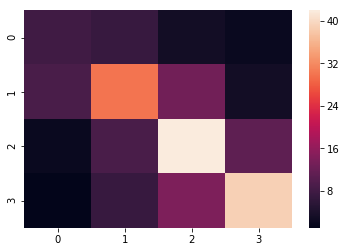

In [11]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [12]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [13]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [14]:
krippendorffs_alpha(anno.annotations[::])

0.6472588223831547

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [15]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

In [16]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.43917037 0.47677621        nan        nan        nan
  0.45819119 0.43381462]
 [0.43917037 1.         0.38432922 0.41344423        nan        nan
         nan 0.33643611]
 [0.47677621 0.38432922 1.         0.39583333 0.51704894        nan
         nan        nan]
 [       nan 0.41344423 0.39583333 1.         0.34597068 0.4446844
         nan        nan]
 [       nan        nan 0.51704894 0.34597068 1.         0.37938644
  0.43039733        nan]
 [       nan        nan        nan 0.4446844  0.37938644 1.
  0.38341929 0.31214748]
 [0.45819119        nan        nan        nan 0.43039733 0.38341929
  1.         0.394806  ]
 [0.43381462 0.33643611        nan        nan        nan 0.31214748
  0.394806   1.        ]]


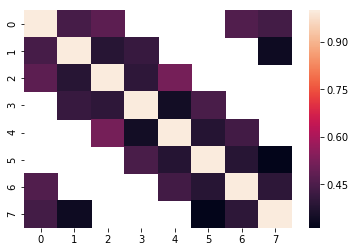

In [17]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others. 

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [18]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [19]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [20]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

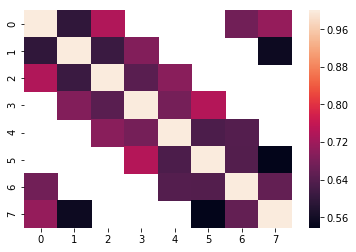

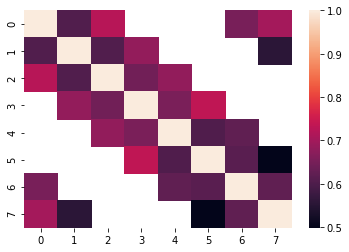

In [21]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [22]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


## <span style="color:red">*Excercise 2*</span>

<span style="color:red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the MTurk slides on this week's Canvas page.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

In [166]:
import warnings
warnings.filterwarnings("ignore")

In [154]:
# Get and create dataframe for Question 1: Is this article title related to climate change?
batch_results = pandas.read_csv("batch_results.csv")
q1 = batch_results.groupby(['HITId','WorkerId'])['Answer.Q1Answer'].first().unstack()
q1.fillna(-1, inplace=True)
q1 = q1.values
anno_q1 = AnnotationsContainer.from_array(q1, missing_values=[-1])

In [155]:
# 116 questions, 33 reviewers
q1.shape 

(116, 33)

In [156]:
# Frequency of 0 and 1
pyanno.measures.agreement.labels_frequency(anno_q1.annotations,2)

array([0.42708333, 0.57291667])

In [160]:
def compareTwo(annot, i, j, numCat):
    # Confusion matrix of 
    c = pyanno.measures.agreement.confusion_matrix(annot.annotations[:,i], annot.annotations[:,j], numCat)
    print(c)
    ac = seaborn.heatmap(c)
    plt.show()
    
    print("Scott's pi: ", scotts_pi(annot.annotations[:,i], annot.annotations[:,j]))  
    print("Cohen's kappa: ", cohens_kappa(annot.annotations[:,i], annot.annotations[:,j]))
    print("Cohen's weighted kappa: ", cohens_weighted_kappa(annot.annotations[:,i], annot.annotations[:,j]))      

[[38.  8.]
 [ 2. 52.]]


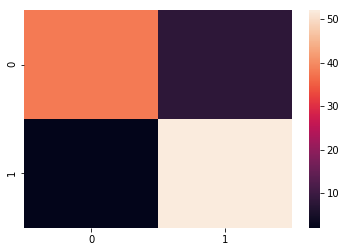

Scott's pi:  0.7970595911265768
Cohen's kappa:  0.7975
Cohen's weighted kappa:  0.7975


In [161]:
# Compare persons 6 and 26: both completed 107 questions out of 116
compareTwo(anno_q1, 6, 26, 2)

In [170]:
def compareAll(annot):
    print("Krippendorff's alpha: ", krippendorffs_alpha(annot.annotations[::]))
    print("Pairwise Cohen's kappas")
    m = pairwise_matrix(cohens_kappa, annot.annotations)
    ax = seaborn.heatmap(m)
    plt.show()
    print("Averages")
    print("Average Cohen's kappa: ", pairwise_metric_average(cohens_kappa, annot.annotations))
    print("Average Cohen's weighted kappa: ", pairwise_metric_average(cohens_weighted_kappa,annot.annotations))
    print()
    print("Correlations")
    n = pairwise_matrix(pearsons_rho, annot.annotations)
    m = pairwise_matrix(spearmans_rho, annot.annotations)
    an = seaborn.heatmap(n)
    plt.show()
    print("Average Pearson's rho: ", pairwise_metric_average(pearsons_rho,annot.annotations))
    am = seaborn.heatmap(m)
    plt.show()
    print("Average Spearman's rho: ", pairwise_metric_average(spearmans_rho,anno_q1.annotations))
        

Krippendorff's alpha:  0.670639320029564
Pairwise Cohen's kappas


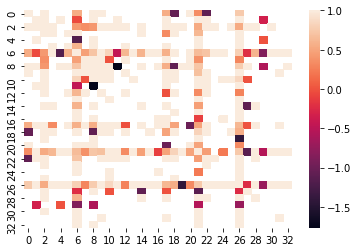

Averages
Average Cohen's kappa:  0.6818131020745188
Average Cohen's weighted kappa:  0.681813102074519

Correlations


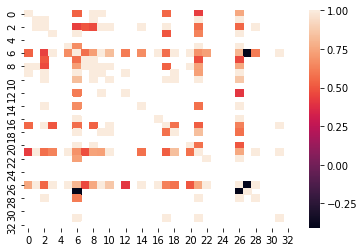

Average Pearson's rho:  0.7708791912138041


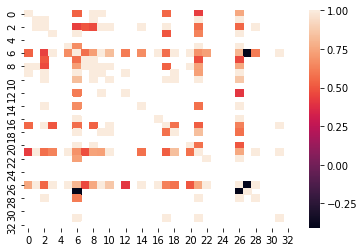

Average Spearman's rho:  0.7708791912138042


In [171]:
# Compare all annotators
compareAll(anno_q1)

In [173]:
# Get and create dataframe for Question 2: How political is this article title?
q2= batch_results.groupby(['HITId','WorkerId'])['Answer.Q2Answer'].first().unstack()
q2.fillna(-1, inplace=True)
q2 = q2.values
anno_q2 = AnnotationsContainer.from_array(q2, missing_values=[-1])

[[13. 19.  3.  1.  0.]
 [ 4.  3.  2.  4.  2.]
 [ 0.  2.  3.  1.  3.]
 [ 1.  0.  6.  5.  7.]
 [ 1.  3.  4.  6.  9.]]


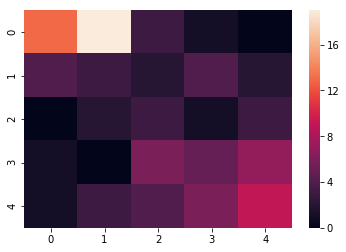

Scott's pi:  0.14466667930262164
Cohen's kappa:  0.15891299485573698
Cohen's weighted kappa:  0.4327545232189013


In [175]:
# Compare persons 6 and 26: both completed 107 questions out of 116
compareTwo(anno_q2, 6, 26, 5)

Krippendorff's alpha:  0.38097544651458115
Pairwise Cohen's kappas


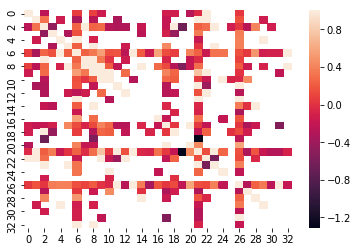

Averages
Average Cohen's kappa:  0.14737652386833364
Average Cohen's weighted kappa:  0.25509313177579435

Correlations


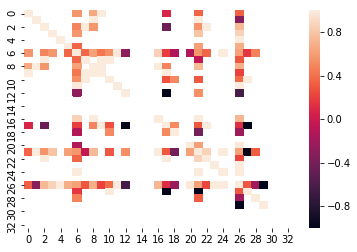

Average Pearson's rho:  0.4509333392303114


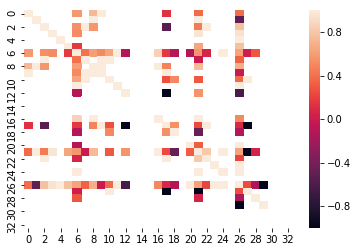

Average Spearman's rho:  0.7708791912138042


In [176]:
compareAll(anno_q2)

In [177]:
# Get and create dataframe for Question 3: How environmental is this article title?
q3= batch_results.groupby(['HITId','WorkerId'])['Answer.Q3Answer'].first().unstack()
q3.fillna(-1, inplace=True)
q3 = q3.values
anno_q3 = AnnotationsContainer.from_array(q3, missing_values=[-1])

[[ 7. 11.  2.  2.  2.]
 [ 5.  2.  5.  1.  1.]
 [ 4.  1.  5.  0.  0.]
 [ 2.  5. 10.  2. 10.]
 [ 0.  1.  3.  2. 19.]]


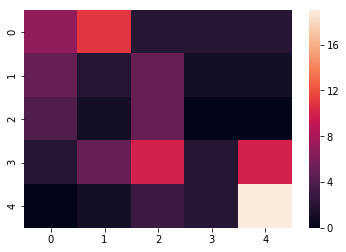

Scott's pi:  0.16662007854025263
Cohen's kappa:  0.1864543982730707
Cohen's weighted kappa:  0.4276067022051596


In [178]:
compareTwo(anno_q3, 6, 26, 5)

Krippendorff's alpha:  0.4892052575413518
Pairwise Cohen's kappas


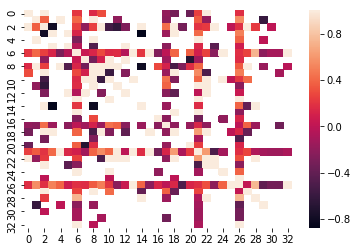

Averages
Average Cohen's kappa:  0.21731106341283227
Average Cohen's weighted kappa:  0.3933132301963792

Correlations


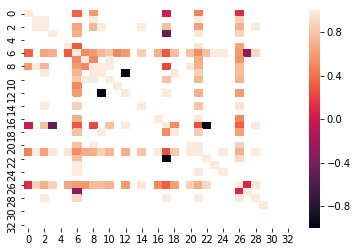

Average Pearson's rho:  0.657704063692193


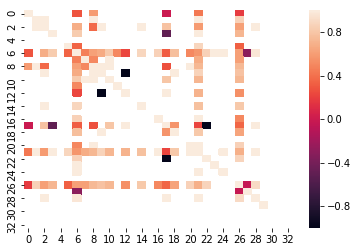

Average Spearman's rho:  0.7708791912138042


In [179]:
compareAll(anno_q3)

In [180]:
# Get and create dataframe for Question 4: How economic is this article title?
q4= batch_results.groupby(['HITId','WorkerId'])['Answer.Q4Answer'].first().unstack()
q4.fillna(-1, inplace=True)
q4 = q4.values
anno_q4 = AnnotationsContainer.from_array(q4, missing_values=[-1])

[[ 9.  3.  1.  1.  0.]
 [ 2.  1.  0.  0.  1.]
 [ 0.  1.  2.  1.  1.]
 [ 1.  4.  7. 12. 15.]
 [ 1.  4.  6. 11. 18.]]


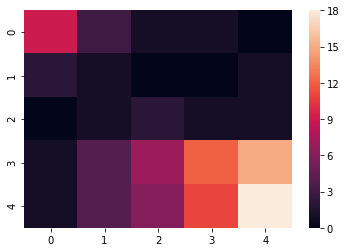

Scott's pi:  0.20314423015657435
Cohen's kappa:  0.21232695061793877
Cohen's weighted kappa:  0.4288140647486678


In [181]:
compareTwo(anno_q4, 6, 26, 5)

Krippendorff's alpha:  0.33667776429911234
Pairwise Cohen's kappas


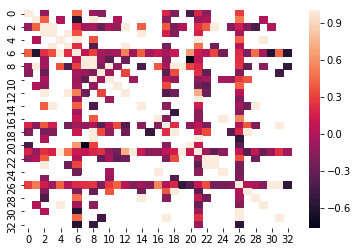

Averages
Average Cohen's kappa:  0.11364803796526053
Average Cohen's weighted kappa:  0.20133467380606226

Correlations


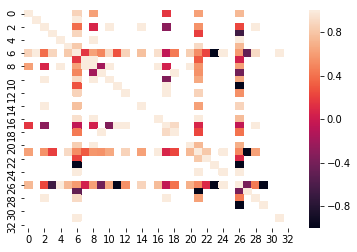

Average Pearson's rho:  0.47246089435028094


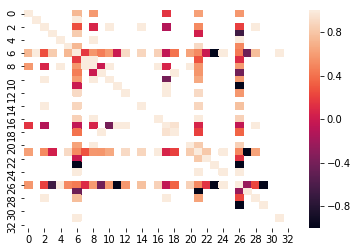

Average Spearman's rho:  0.7708791912138042


In [182]:
compareAll(anno_q4)

## <span style="color:blue">*Notes 2*</span>

<span style="color:blue"> We asked mechanical Turks to answer 4 questions. Given newspaper article titles, 1) is it relevant to 'climate change', 2) how relevant is it to the political domain, 3) how relevant is it to the environmental domain, 4) how relevant is it to the economic domain? The first question was yes/no, while the latter 3 were on a scale from 1-5. This is an important question, as some of the articles seem to only be marginally related to the topic climate change. Also, we decided to provide only the title and not the entire article (since the conent of the article is largely reflected in the title). Up to 6 people could answer the questions for each title. There were 116 titles, and 33 people responded for 1 to 107 titles.  

<span style="color:blue"> There were 2 responders who answered 107 out of 116. These two were compared for the two responder comparisons, as they answered the most number of questions in common (100 in common). For the 'relevant to climate change', the two frequent responders agree at at very high rate, at about .80 for pi, kappa, and weighted kappa. This is somewhat higher than the overall agreement (alpha), which was .67. The average (weighted) kappa was about the same. This shows that frequent responders are more likely to agree with each other, and may indicate that they are more "accurate". 

<span style="color:blue"> There was far less agreement in the how relevant is it to a domain questions (probably because it is a scale). The weighted kappas will be compared, as taking into account light/severe disagreements is meaningful (one person saying 4, another saying 5 is not such a big difference). Again, we see that the two frequent reviewers are more likely to be in agreement than average; their weighted kappas are about .43 for all three 'relevant to domain' questions. In comparison, the average weighted kappas varied: .2 (economic), .25 (political), .39 (environmental). The averages were generally (much) lower than the weighted kappa for the high responders. The average correlations were also assessed, though this may be less meaningful since the data are not real values.

<span style="color:blue"> We can see that there is much more agreement in binary questions, the answers to which may be more reliable. There is much more variation in questions that ask you to rank something on a scale. High responders are probably more likely to agree than average, which may indicate more reliability. 

# Models

However, what if some coders are better than others. The prior measures all rely on the assumption that all coders are equally good. What if some are worse than others? Now we use Rzhetsky et al (2009) and Dawid & Skene's models to make inference about true label classes by downweighting bad or deviant coders. Pyanno provides two relevant models: ModelB and ModelBt. Model B with $\theta$s models the relationship between each coder and code. Model B is a Bayesian generalization of the Dawid & Skene model from the reading. The following image schematically describes these models. <img src="../data/pyanno/Bmodel.png">

The models should provide very similar results. To estimate the parameters for any models, we first need to create a new model. 

In [23]:
# create a new instance of model B, with 4 label classes
model = ModelB.create_initial_state(4,8)
# other model parameters are initialized from the model prior
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[0.72366414 0.16861163 0.03500319 0.07272104]
  [0.15873627 0.7012563  0.08239688 0.05761055]
  [0.08731773 0.1461395  0.53484717 0.2316956 ]
  [0.04789214 0.04982343 0.21948148 0.68280295]]

 [[0.80908389 0.09386857 0.00428423 0.0927633 ]
  [0.10789787 0.67852268 0.19327195 0.0203075 ]
  [0.06942406 0.2265322  0.54090939 0.16313435]
  [0.07481628 0.05621987 0.03780544 0.83115841]]

 [[0.46512665 0.24536336 0.08476028 0.20474971]
  [0.3289182  0.49210585 0.10847156 0.07050439]
  [0.0928711  0.22503891 0.62769494 0.05439505]
  [0.08720139 0.03749873 0.11187131 0.76342857]]

 [[0.77713643 0.16452109 0.01337347 0.04496901]
  [0.18410083 0.56878527 0.13640556 0.11070835]
  [0.03231322 0.08759271 0.60337636 0.27671771]
  [0.07861656 0.13484001 0.13695339 0.64959004]]

 [[0.59943108 0.21696502 0.02726112 0.15634278]
  [0.10150768 0.5909883  0.07439579 0.23310823]
  [0.07281562 0.06603893 0.67464607 0.18649939]
  [0.00783409 0.12151263 0.08600692 0.78464637]]

 [[0.74772934 0.1925     0.048

Now we train the model on our data. Pyanno allows one to use either MAP (maximum a posteriori estimation) or MLE (maximum likelihood estimation) to estimate model parameters. Note that the parameters here correspond to our estimation of the accuracy of each annotator-annotation pair. First we will train with MAP, and then you can optionally training with MLE.

In [24]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

In [25]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[7.73398728e-01 2.01020245e-01 2.55810269e-02 1.20101219e-26]
  [1.47832659e-01 7.11503767e-01 7.66499157e-02 6.40136580e-02]
  [1.97431020e-02 1.48708709e-01 6.96639326e-01 1.34908863e-01]
  [2.52463780e-18 2.13647377e-02 8.51550428e-02 8.93480220e-01]]

 [[7.19395465e-01 2.01828761e-01 7.87757734e-02 1.55486964e-13]
  [1.33941799e-01 7.07223261e-01 1.10418200e-01 4.84167403e-02]
  [2.72093282e-02 1.65178369e-01 6.71232700e-01 1.36379603e-01]
  [2.15358721e-30 5.38211823e-02 1.21871740e-01 8.24307077e-01]]

 [[8.50073137e-01 1.22955501e-01 2.69713621e-02 3.64395738e-42]
  [8.93514251e-02 7.89280333e-01 8.93429608e-02 3.20252811e-02]
  [6.11638366e-02 1.29121422e-01 7.03992731e-01 1.05722011e-01]
  [6.53666390e-03 5.12606512e-02 2.10869595e-01 7.31333090e-01]]

 [[6.99612801e-01 2.70976969e-01 2.94102301e-02 8.57899704e-52]
  [9.67171336e-02 7.62615701e-01 1.09523823e-01 3.11433425e-02]
  [1.81150586e-02 1.45472330e-01 6.85587954e-01 1.50824657e-01]
  [2.71897111e-47 2.98511124e-02 2

Uncomment the cell below if you would rather train by MLE.

In [ ]:
#model = ModelB.create_initial_state(4,8)
#model.mle(anno.annotations)
#print(model.theta)
#print(model.log_likelihood(anno.annotations))

Once we have model parameters estimated, we can now make inferences about the true label classes. We can calculate the posterior distribution over the true label classes.

In [26]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[1.20741380e-42 1.00240780e-01 7.90821679e-01 1.08937540e-01]
 [9.92682453e-01 7.07056554e-03 2.46981317e-04 2.03944498e-49]
 [1.07420297e-03 5.51435353e-02 9.37476514e-01 6.30574822e-03]
 ...
 [8.15378491e-04 3.51193436e-02 9.59859130e-01 4.20614824e-03]
 [1.34481992e-44 2.14447325e-03 9.16166870e-01 8.16886569e-02]
 [2.14745550e-01 7.69057353e-01 1.61970966e-02 2.01807019e-26]]


Let's turn the posterior of the first 100 samples into a heatmap and compare with the raw vote tallies.

In [27]:
def makeQuestionComparison(model, anno_target, num_questions = 20):
    votes = []
    for r in anno_target.annotations:
        v = [0] * len(anno_target.labels)
        votes.append(v)
        for a in r:
            if a > -1:
                v[a] += 1
    votes_array = np.array(votes)
    posterior = model.infer_labels(anno_target.annotations)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)

    seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
    seaborn.heatmap(np.nan_to_num(posterior,0)[:num_questions], annot=True, ax =ax1)
    ax1.set_title("Model")
    ax2.set_title("Votes")
    return fig, (ax1, ax2)

(<matplotlib.figure.Figure at 0x1b35a73c860>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1b35e9584e0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1b35ea4db38>))

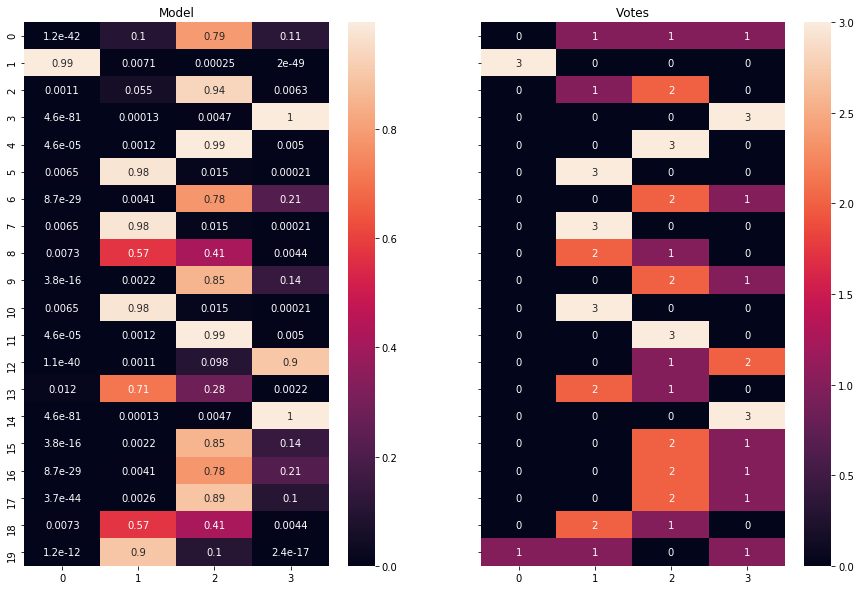

In [28]:
makeQuestionComparison(model, anno)

This differs markedly from taking annotator scores at face value. As you can see (the model-based probabilities are on left; the raw votes on right), the models helps us break ties between coders and in some cases dramatically downgrades the estimates from particularly bad coders.

Let's try everything again with ModelBt, which constrains ModelB so that each coder has a single estimate over the accuracy of all of their codes.

In [29]:
# create a new instance of model B, with 4 label classes and 8 annotators.
model = ModelBt.create_initial_state(4, 8)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.69021753 0.80261963 0.68360135 0.87739913 0.85943471 0.68562683
 0.91612983 0.9446566 ]
-3733.6311545650333


In [30]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.79142956 0.74075948 0.76224792 0.72520812 0.71643558 0.71861446
 0.77322273 0.71665748]
-2811.946478563244


In [31]:
model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

array([[0.76297795, 0.73334505, 0.76368076, ..., 0.70650318, 0.83399285,
        0.73490817],
       [0.76297795, 0.73334505, 0.76368076, ..., 0.70650318, 0.83399285,
        0.73490817],
       [0.76297795, 0.73334505, 0.76368076, ..., 0.70650318, 0.83399285,
        0.73490817],
       ...,
       [0.80145042, 0.79447533, 0.75929426, ..., 0.71359186, 0.77778278,
        0.64433547],
       [0.80145042, 0.79447533, 0.75929426, ..., 0.71359186, 0.77778278,
        0.64433547],
       [0.80145042, 0.79447533, 0.75929426, ..., 0.71359186, 0.77778278,
        0.64433547]])

In [32]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[0.01109932 0.28942948 0.36489225 0.33457895]
 [0.99023057 0.00241675 0.00404613 0.00330656]
 [0.00249747 0.05502486 0.93465042 0.00782725]
 ...
 [0.00252682 0.04391985 0.9456341  0.00791923]
 [0.00249184 0.00570801 0.93254181 0.05925834]
 [0.03186983 0.93885918 0.01610761 0.01316338]]


Let's visualize the posterior of the first 10 samples according to ModelBt.

(<matplotlib.figure.Figure at 0x1b35a6a6748>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1b35ea24d68>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1b361615908>))

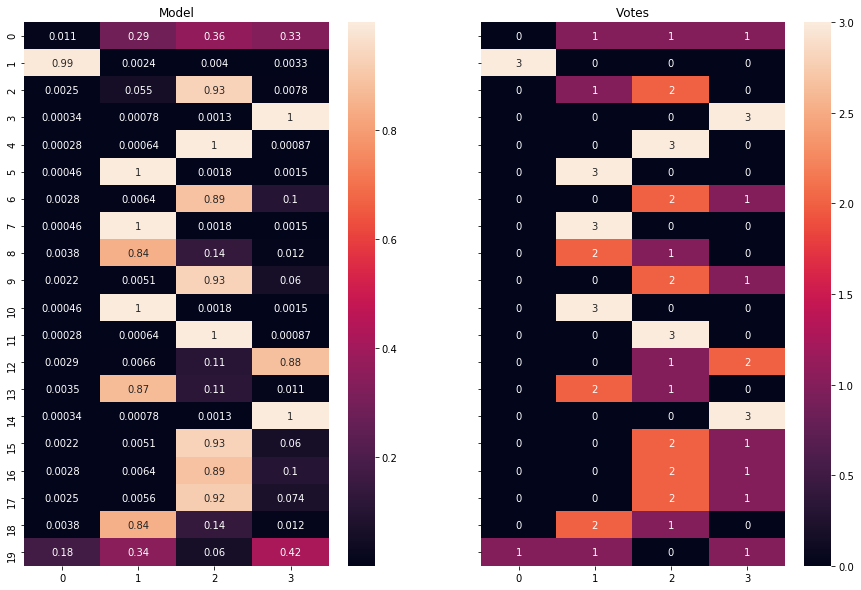

In [33]:
makeQuestionComparison(model, anno)

The property of these scores is that they enable us to identify the most likely code assuming coders of unequal quality, which also allows us to break ties when we know coder identity. We may also use the posterior themselves rather than the most probably code outcome.

## Visualizing coder accuracy

Let's make a plot of the accuracy for each annotator inferred from ModelBt. This might be helpful if you wanted to ban a "troll" from your crowdsourcing enterprise. The coder a very low accuracy likelihood is an outlier and should be "dropped from the team."

In [34]:
model = ModelBt.create_initial_state(4,8)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)
y_ci = samples.std(axis=0)

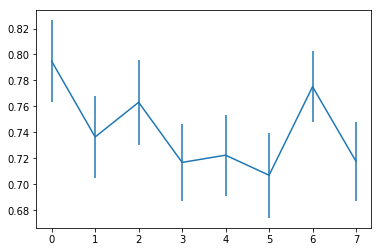

In [35]:
plt.figure()
plt.errorbar(range(8),y, yerr = y_ci)
plt.show()

# Hotel Reviews

If we want to do a simpler analysis we can look at a different data set, here are some hotel reviews from [expedia](https://www.kaggle.com/c/expedia-hotel-recommendations)

In [36]:
df_hotels = pandas.read_csv('../data/hot_Reviews.csv', index_col=0)
df_hotels[:5]

,Karen,Scott,Jessica,write a review,A verified traveler,Kevin,William,R,S,Christopher,...,Thomas,Susan,A Traveler,M,Not Provided,B,Laura,xxxxxxxxxxxxxx,Michael,Joseph
1785 Inn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900 House,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Bed & Breakfast In Cambridge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Swallow's Nest Motel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abbeville Inn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here a rank of 0 is a missing value and to simplify things more we will convert from a 1-10 scale to a 1-5 scale, with 0 as missing

In [37]:
df_hotels = df_hotels.apply(lambda x: x // 2) #integer divide by 2 rounds all values

And we can visualize all the reviews as a heatmap with the missing values greyed out

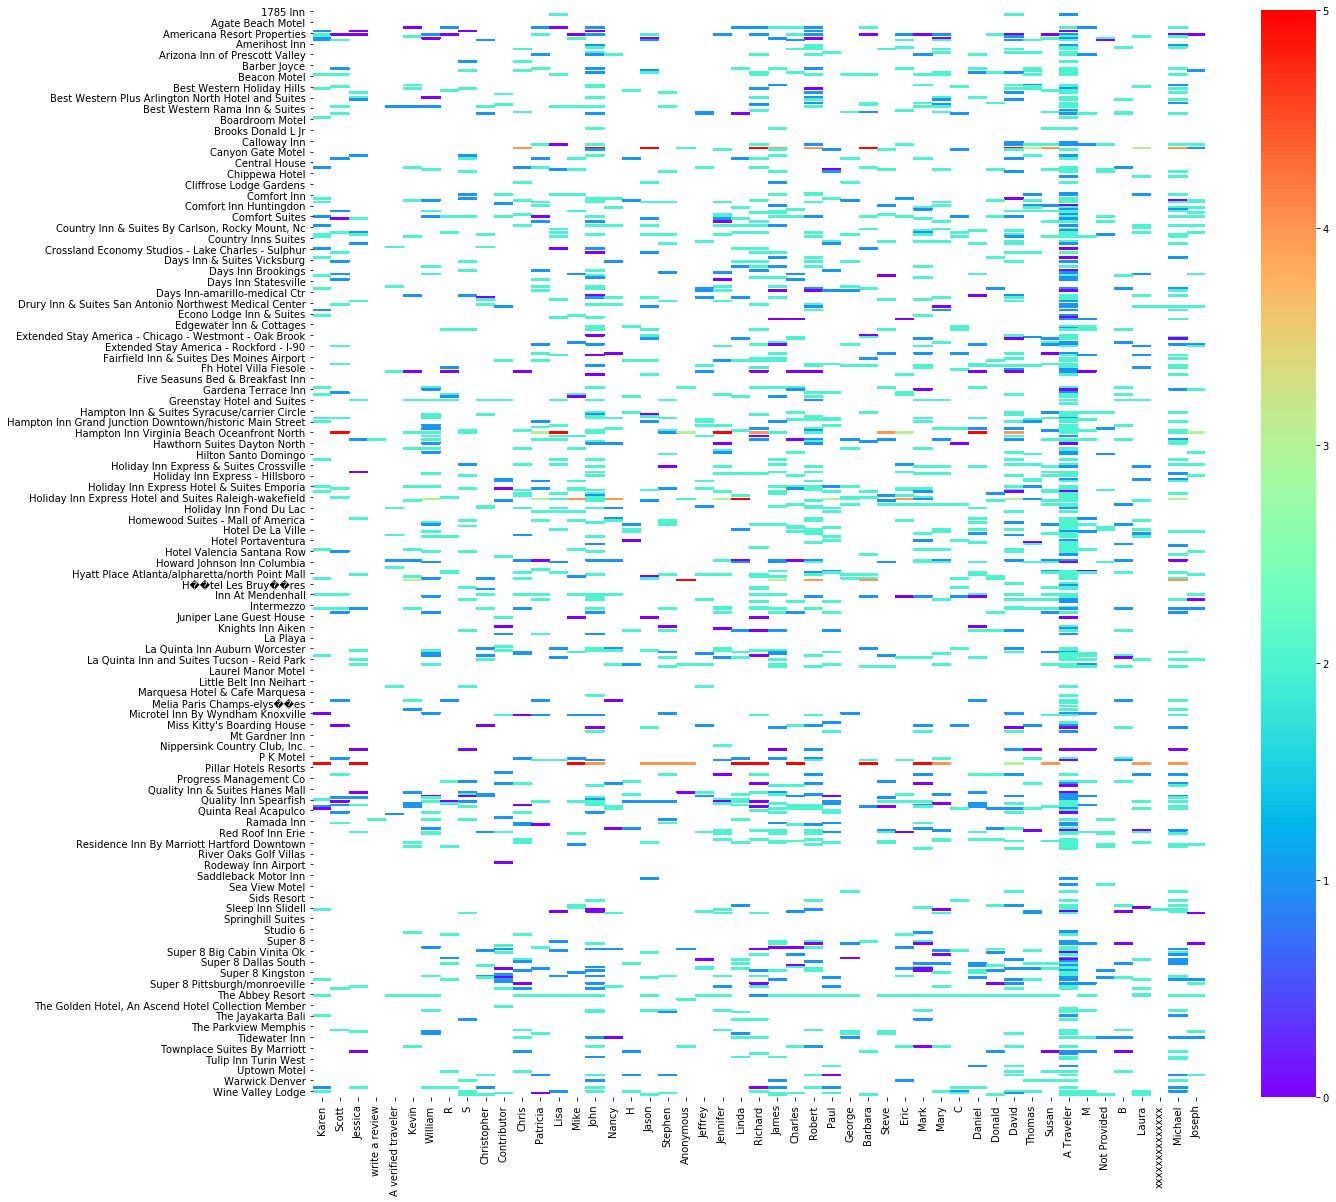

In [38]:
fig, ax = plt.subplots(figsize = (20,20))
seaborn.heatmap(df_hotels, cmap='rainbow', ax = ax)
plt.show()

To give the dataframe to pyanno we need to convert to np array and change the nans to intergers, lets use -1

In [39]:
hot_mat = np.array(df_hotels.fillna(-1).as_matrix())
anno_hot = AnnotationsContainer.from_array(hot_mat, missing_values=[-1])

In [40]:
anno_hot.annotations

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [41]:
anno_hot.labels

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

In [42]:
anno_hot.missing_values

[-1]

Look at coder agreement

In [43]:
pyanno.measures.agreement.labels_frequency(anno_hot.annotations, 6)#6 possible catagories

array([0.07806534, 0.26262198, 0.63555367, 0.00636402, 0.0093339 ,
       0.00806109])

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 4. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


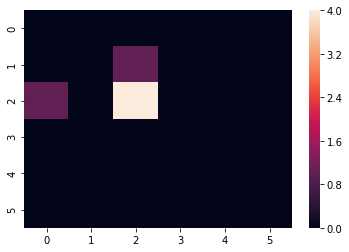

In [44]:
c = pyanno.measures.agreement.confusion_matrix(anno_hot.annotations[:,0], anno_hot.annotations[:,1], 6) #6 possible catagories
print(c)
ac = seaborn.heatmap(c)
plt.show()

Most agreement is on 2 i.e. an average hotel and there's little agreement as rating go higher, likely due to scarcity in the sample

In [45]:
scotts_pi(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

0.3787878787878787

In [46]:
krippendorffs_alpha(anno_hot.annotations[::])

0.398760907615921

In [47]:
cohens_kappa(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

0.40328336902212697

C:\ProgramData\Anaconda3\lib\site-packages\pyanno\measures\helpers.py:166: RuntimeWarning: invalid value encountered in double_scalars
  return (observed_agreement - chance_agreement) / (1. - chance_agreement)


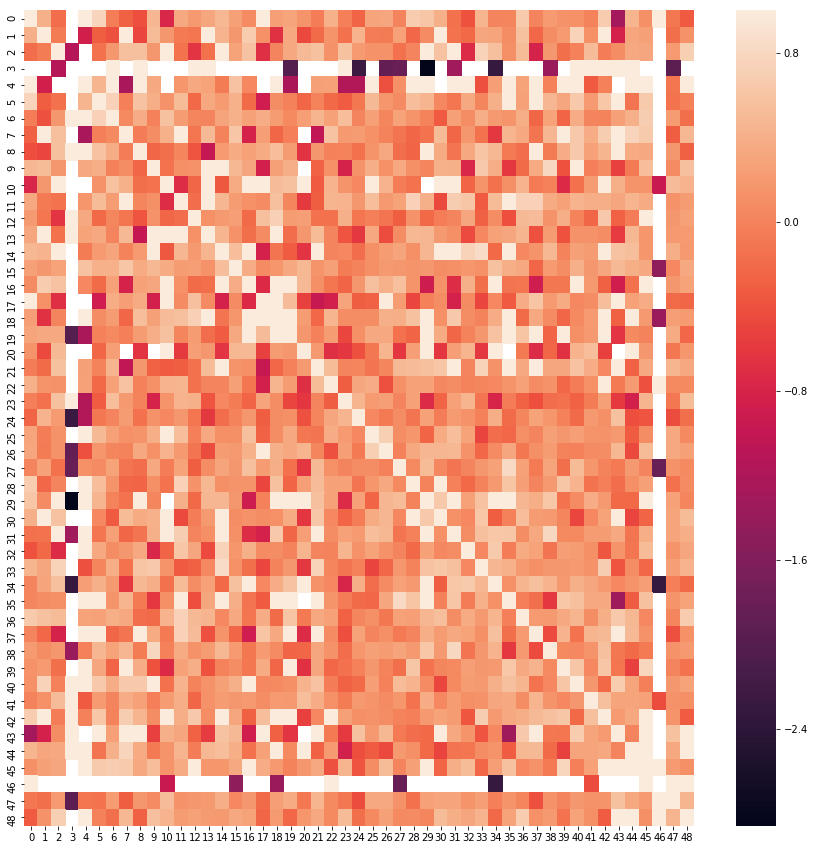

In [48]:
m = pairwise_matrix(cohens_kappa, anno_hot.annotations)
fig, ax = plt.subplots(figsize = (15, 15))
seaborn.heatmap(m, ax =ax)

And to look at what model Bt thinkgs the correct reviews are:

In [49]:
model_hot = ModelBt.create_initial_state(6, 49)
model_hot.mle(anno_hot.annotations)
#print(model.theta)
print(model_hot.log_likelihood(anno_hot.annotations))

-2710.072800128794


(<matplotlib.figure.Figure at 0x1b35e22c2b0>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1b35e2289b0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1b360cd4198>))

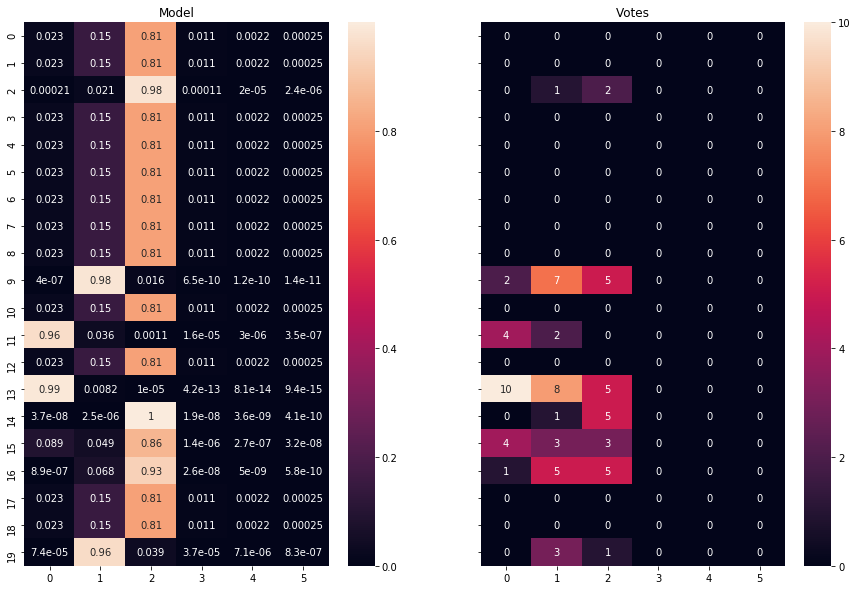

In [50]:
makeQuestionComparison(model_hot, anno_hot)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, use the results of your content annotation survey to predict high and low-quality analysts, then predict MLE or MAP estimates for your codes in question. What do these estimates suggest about the distribution of skill among your coders? How different are these estimates from a majority vote?